In [8]:
from netgen.geom2d import unit_square
from ngsolve import *
from ngsolve import grad as ngsolvegrad
from ngsolve.comp import ProxyFunction
from ngsolve.webgui import Draw
#import netgen.gui
import numpy as np
import sympy 
from scipy import linalg
import pandas as pd
from ngsolve.webgui import Draw as WebGuiDraw
import sys

#### Configuration Setup

In [9]:
beta = (2,0.001)
eps = 0.01

p = lambda x: x + (exp(beta[0]*(x-1)/eps)-exp(-beta[0]/eps))/(exp(-beta[0]/eps)-1)
q = lambda y: y + (exp(beta[1]*(y-1)/eps)-exp(-beta[1]/eps))/(exp(-beta[1]/eps)-1)

exact = p(x) * q(y)
coeff =  beta[1] * p(x) +  beta[0] * q(y)


config = {
    'order': [1, 2, 3, 4],
    'beta': (2,0.001),
    'mesh_size': [1.0, 0.5, 0.25, 0.125, 0.0625],
    'epsilon': 0.01,
    'exact': exact,
    'coeff': coeff,
    'alpha': [100],
    'bonus_int_order' : [10],
    'enrich_functions':[p(x), q(y)],
    'correction': False,
    'enrich_domain_ind':[lambda x,y,h: x > 1 - h/2, lambda x,y,h: y > 1 - h/2]
}


columns = ['Order', 'Mesh Size', 'Error', 'Alpha', 'Bonus Int', 'Type']
dg_table = pd.DataFrame(columns=columns)
hdg_table = pd.DataFrame(columns=columns)

#### Enrichment Proxy Functions for the DG method

In [10]:
class EnrichmentProxy(CoefficientFunction):
    """
    Provide wrappers for grad/Other and multiplication of enrichment lists for the DG Method.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]

    def __call__(self):
        return self.func[0] + sum([self.func[i]*self.enr_list[i-1] for i in range(1,len(self.enr_list)+1)])

    def x(self):
        return sum([self.func[i]*self.enr_list[i-1] for i in range(1,len(self.enr_list)+1)])
    
    ## Runs the default without enrichment
    def base(self):
        return self.func[0]
    
    def __mul__(self, other):
        if type(other) == EnrichmentProxy:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self,other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)
    
    #gradient of newly enriched approximation spaces
    def grad(self):
        mygrad = ngsolvegrad(self.func[0])
        for i in range(1,len(self.enr_list)+1):
            mygrad += self.func[i] * self.grad_list[i-1]
            mygrad += ngsolvegrad(self.func[i])*self.enr_list[i-1]
        return mygrad 
    
    
    '''define proxy functions for Other'''
    def Other(self):
        return EnrichmentProxy([f.Other() for f in self.func],self.enr_list)

#### Enrichment Proxy Functions for the HDG method

In [11]:
class EnrichmentProxy_VOL(CoefficientFunction):
    """
    Provide wrappers for grad/Other and multiplication of enrichment lists for the HDG method.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]
    
    def __call__(self):
        return self.func[0] + sum([self.func[2 + 2* i] * self.enr_list[i] for i in range(0,len(self.enr_list))])

    def x(self):
        return sum([self.func[2+2*i]*self.enr_list[i] for i in range(0,len(self.enr_list))])
    
    def base(self):
        return self.func[0]

    def __mul__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self, other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)
    
    
    '''gradient of newly enriched approximation spaces'''
    def grad(self):
        mygrad = ngsolvegrad(self.func[0])
        for i in range(len(self.enr_list)):
            mygrad += self.func[2+2*i] * self.grad_list[i]
            mygrad += ngsolvegrad(self.func[2+2*i])* self.enr_list[i]
        return mygrad

def grad(q):
    if type(q) == ProxyFunction:
        return ngsolvegrad(q)
    else:
        return q.grad()


In [12]:
class EnrichmentProxy_FAC(CoefficientFunction):
    """
    Provide wrappers for the facets.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]
    
    
    def __call__(self):
        return self.func[1] + sum([self.func[3 + 2*i]*self.enr_list[i] for i in range(0,len(self.enr_list))])

    def x(self):
        return sum([self.func[3 + 2*i]*self.enr_list[i] for i in range(0,len(self.enr_list))])

    def base(self):
        return self.func[1] 
    
    def __mul__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self,other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)


#### Functions to mark/select elements to be enriched

In [13]:
'''Mark elements in the mesh to be enriched'''
def mark_element(Q, mesh, enr_indicator, mesh_size):
    ba = BitArray(Q.ndof)        
    ba.Clear()
    for el in Q.Elements():
        mark = False
        for v in el.vertices:
            if (enr_indicator(mesh[v].point[0],mesh[v].point[1],mesh_size)):
                mark = True
        for dof in el.dofs:
            ba[dof] = mark
        Qx = Compress(Q, active_dofs=ba)     
    return Qx


'''Mark elements boundaries (facets) in the mesh to be enriched'''
def mark_element_bnd(Q, QF, mesh, enr_indicator, mesh_size):
    ba = BitArray(Q.ndof)        
    ba.Clear()
    for el in Q.Elements():
        mark = False
        for v in el.vertices:
            if (enr_indicator(mesh[v].point[0],mesh[v].point[1],mesh_size)):
                mark = True
        for dof in el.dofs:
            ba[dof] = mark

    gfF = GridFunction(QF)     
    gfF.vec[:] = 0
    for el in QF.Elements():
        if ba[el.nr]:
            for dof in el.dofs:
                gfF.vec[dof] += 1
    ba_F = BitArray(QF.ndof)
    ba_F.Clear()
    for i in range(QF.ndof):
        if gfF.vec[i] > 0.5:
            ba_F[i] = True
    QFx = Compress(QF, active_dofs=ba_F) 
    return QFx

In [14]:
"""
(Hybrid) Discontinuous Galerkin Method with Upwinding
"""

class Convection_Diffusion():
    
    '''Specify default parameters if necessary (ANY?)'''
    config = {
    }
    
    def __init__(self, new_config={}):
        self.config.update(new_config) #Updates the configuration parameters with the user input        
    
    '''Solves the convection-diffusion equations by the DG methods using upwinding'''
    def _solveDG(self):
        dg_table.iloc[0:0]
        for order in self.config['order']:
            for size in self.config['mesh_size']:
                for alpha in self.config['alpha']:
                    for bonus_int in self.config['bonus_int_order']:
                        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
                        V = L2(mesh, order=order, dgjumps=True)        
                        Vlist = [V]
                        Q = L2(mesh, order=0)
                            
                        for enr_indicator in self.config['enrich_domain_ind']:
                            Vlist.append(mark_element(Q,mesh,enr_indicator, size))
                        
                        fes = FESpace(Vlist, dgjumps = True)

                        u = EnrichmentProxy(fes.TrialFunction(), self.config['enrich_functions'])
                        v = EnrichmentProxy(fes.TestFunction(), self.config['enrich_functions'])


                        # # Checking linear dependence
                        # # Get active elements from the enrichment
                        ipintegrator = SymbolicBFI(u() * v(),bonus_intorder=20)
                        ba_active_elements = BitArray(mesh.ne)
                        #ba_active_elements[:] = True  # <-- todo (get this from before...)
                        
                        # # Get dofs
                        ba_active_dofs = BitArray(fes.FreeDofs())
                        ba_active_dofs[:] = fes.FreeDofs()
                        
                        ## apply algorithm on each element
                        for el in fes.Elements():
                            if ba_active_elements[el.nr]:
                                i = ElementId(el)
                                element = fes.GetFE(el)
                                elementstd = V.GetFE(i)
                                Nstd = elementstd.ndof
                                trafo = mesh.GetTrafo(i)
                                # Get element matrix 
                                elmat = ipintegrator.CalcElementMatrix(element, trafo)           
                                N = len(el.dofs)
                                important = [True  if el.dofs[i]>=0 else False for i in range(N)]
                                before_important = [True  if el.dofs[i]>=0 else False for i in range(N)]
                                
                                factors=[]
                                for i in range(Nstd,N):
                                  if important[i]:
                                    active = [j for j in range(i) if important[j]]
                                    factor = 1 - 2 * sum([elmat[i,j]**2/elmat[i,i]/elmat[j,j] for j in active])
                                    factor += sum([elmat[i,j]*elmat[i,k]*elmat[j,k]/elmat[i,i]/elmat[j,j]/elmat[k,k] for j in active for k in active])
                                    factor = sqrt(abs(factor))
                                    factors.append(factor)
                                    #print(factor)
                                    if (factor < 1e-5):
                                        important[i] = False
                                        if el.dofs[i] >= 0:
                                            ba_active_dofs[el.dofs[i]] = False
                                # if (len(factors)>0):        
                                #     U, s, V = linalg.svd(elmat)
                                #     new_mat = U @ np.diag(s) @ V
                                #     print(elmat == new_mat)
                        jump_u = u-u.Other()
                        jump_v = v-v.Other()

                        n = specialcf.normal(2)
                        mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
                        mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

                        h = specialcf.mesh_size
                        dy = dx(bonus_intorder = bonus_int)
                        dX = dx(skeleton=True, bonus_intorder= bonus_int)
                        dS = ds(skeleton=True, bonus_intorder= bonus_int)

                        # diffusion equation
                        diffusion = grad(u) * grad(v) * dy \
                            + alpha * order ** 2/ h * jump_u * jump_v * dX \
                            +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dX \
                            +alpha * order ** 2/h * u * v * dS \
                            + (-n * grad(u) * v -n * grad(v) * u) * dS

                        # convection equation
                        b = CoefficientFunction((self.config['beta'][0], self.config['beta'][1]))
                        uup = IfPos(b * n, u(), u.Other()())
                        convection = -b * u * grad(v) * dy + b * n * uup * jump_v * dX

                        acd = BilinearForm(fes)
                        acd += self.config['epsilon'] * diffusion + convection
                        
                        # if self.config['correction']:
                        #     ## added this
                        #     acd += 1e-10 * 1.0/h * u.x() * v.x() * dy
                        
                        with TaskManager():
                            acd.Assemble()

                        # rhs
                        f = LinearForm(fes)
                        f += self.config['coeff'] * v * dy
                        with TaskManager():
                            f.Assemble()

                        gfu = GridFunction(fes, name="uDG")
                        
                        
                        try:
                            gfu.vec.data = acd.mat.Inverse(ba_active_dofs,inverse="umfpack") * f.vec
                        except:
                            gfu.vec.data = acd.mat.Inverse(ba_active_dofs,inverse="sparsecholesky") * f.vec
                        
                        gfu = gfu.components[0] + sum([gfu.components[i+1]*self.config['enrich_functions'][i] for i in range(len(self.config['enrich_functions']))])

                        #WebGuiDraw(gfu,mesh,"u")
                    
                        error = sqrt (Integrate ((gfu-self.config['exact'])*(gfu-self.config['exact']), mesh, order = 30 + bonus_int))
                        dg_table.loc[len(dg_table)] = [order, size, error, alpha, bonus_int, 'edg']

                        print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)

        return dg_table
    
    
    '''Solves the convection-diffusion equations by the HDG 
    methods with the options to either enrich or not'''
    def _solveHDG(self):
        hdg_table.iloc[0:0]
        for order in self.config['order']:
            for size in self.config['mesh_size']:
                for alpha in self.config['alpha']:
                    for bonus_int in self.config['bonus_int_order']:
                        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
                        condense = True
                        h = specialcf.mesh_size
                        n = specialcf.normal(mesh.dim)
                        dS = dx(element_boundary=True, bonus_intorder=bonus_int)
                        dy = dx(bonus_intorder=bonus_int)
                        V = L2(mesh, order=order)
                        F = FacetFESpace(mesh, order=order, dirichlet=".*")
                        Q = L2(mesh, order=0)
                        QF = FacetFESpace(mesh, order=0, dirichlet=".*")

                        Vlist = [V]
                        Vlist.append(F)
                        for enr_indicator in self.config['enrich_domain_ind']:
                            Vlist.append(mark_element(Q,mesh,enr_indicator,size))
                            Vlist.append(mark_element_bnd(Q, QF, mesh,enr_indicator, size))
                                
                        fes = FESpace(Vlist) # [V, F, Qx, QFx, Qy, QFy])
                        u = EnrichmentProxy_VOL(fes.TrialFunction(),self.config['enrich_functions'])
                        v = EnrichmentProxy_VOL(fes.TestFunction(), self.config['enrich_functions'])

                        uhat = EnrichmentProxy_FAC(fes.TrialFunction(),self.config['enrich_functions'])       
                        vhat = EnrichmentProxy_FAC(fes.TestFunction(), self.config['enrich_functions'])
                        

                        # # Checking linear dependence
                        # # Get active elements from the enrichment
                        ipintegrator = SymbolicBFI(u() * v(),bonus_intorder=20)
                        ba_active_elements = BitArray(mesh.ne)
                        #ba_active_elements[:] = True  # <-- todo (get this from before...)
                        
                        # # Get dofs
                        ba_active_dofs = BitArray(fes.FreeDofs())
                        ba_active_dofs[:] = fes.FreeDofs()
                        
                        ## apply algorithm on each element
                        for el in fes.Elements():
                            if ba_active_elements[el.nr]:
                                i = ElementId(el)
                                element = fes.GetFE(el)
                                elementstd = V.GetFE(i)
                                Nstd = elementstd.ndof
                                trafo = mesh.GetTrafo(i)
                                # Get element matrix 
                                elmat = ipintegrator.CalcElementMatrix(element, trafo)           
                                N = len(el.dofs)
                                important = [True  if el.dofs[i]>=0 else False for i in range(N)]
                                before_important = [True  if el.dofs[i]>=0 else False for i in range(N)]
                                
                                factors=[]
                                for i in range(Nstd,N):
                                  if important[i]:
                                    active = [j for j in range(i) if important[j]]
                                    #print(elmat[i,i])
                                    try:
                                        factor = 1 - 2 * sum([elmat[i,j]**2/elmat[i,i]/elmat[j,j] for j in active])
                                        factor += sum([elmat[i,j]*elmat[i,k]*elmat[j,k]/elmat[i,i]/elmat[j,j]/elmat[k,k] for j in active for k in active])
                                        factor = sqrt(abs(factor))
                                        factors.append(factor)
                                        #print(factor)
                                        if (factor < 1e-5):
                                            important[i] = False
                                            if el.dofs[i] >= 0:
                                                ba_active_dofs[el.dofs[i]] = False
                                # if (len(factors)>0):        
                                #     U, s, V = linalg.svd(elmat)
                                #     new_mat = U @ np.diag(s) @ V
                                #     print(elmat == new_mat)
                        
                                    except:
                                        "print nothing"
                        jump_u = u-uhat()
                        jump_v = v-vhat()
                        
                        diffusion = grad(u) * grad(v) * dy \
                        + alpha * order ** 2/h * jump_u * jump_v * dS \
                        + (-grad(u) * n * jump_v - grad(v) * n * jump_u) * dS
                        
                        # convection            
                        b = CoefficientFunction((self.config['beta'][0], self.config['beta'][1]))
                        uup = IfPos(b * n, u(), uhat())
                        
                        convection = -b * u * grad(v) * dy + b * n * uup * v * dS + IfPos( b * n, (uhat()-u)*vhat(), 0) * dS

                        acd = BilinearForm(fes,symmetric=False)
                        acd += self.config['epsilon'] *  diffusion + convection 
                        if self.config['correction']:
                            acd += 1e-10 / h * u.x() * v.x() * dy + 1e-10 * uhat.x() * vhat.x() * dS

                        with TaskManager():
                            acd.Assemble()

                        #rhs
                        f = LinearForm(fes)
                        f += self.config['coeff'] * v * dy
                        
                        with TaskManager():
                            f.Assemble()
                    
                        gfu = GridFunction(fes)
                        
                        try:
                            gfu.vec.data = acd.mat.Inverse(ba_active_dofs,inverse="umfpack") * f.vec
                        except:
                            gfu.vec.data = acd.mat.Inverse(ba_active_dofs,inverse="sparsecholesky") * f.vec

                        gfu = gfu.components[0] + sum([gfu.components[2*i+2] * self.config['enrich_functions'][i] for i in range(len(self.config['enrich_functions']))])
                        
                        error = sqrt (Integrate ((gfu-self.config['exact'])*(gfu-self.config['exact']), mesh, order=100 + bonus_int))
                        hdg_table.loc[len(hdg_table)] = [order, size, error, alpha, bonus_int, 'ehdg']

                        print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)
                
        return hdg_table

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
from functools import reduce
from IPython.display import Image, display
import matplotlib.image as mpimg


def plot_error(table):
    order_1 = table[table.Order.eq(1.0)]
    order_2 = table[table.Order.eq(2.0)]
    order_3 = table[table.Order.eq(3.0)]
    order_4 = table[table.Order.eq(4.0)]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    order_1.plot(x='Mesh Size', y='Error', ax=ax1, legend=True, title='k = 1', style='.-', loglog=True)
    order_2.plot(x='Mesh Size', y='Error', ax=ax2, legend=True, title='k = 2', style='.-', loglog=True)
    order_3.plot(x='Mesh Size', y='Error', ax=ax3, legend=True, title='k = 3', style='.-', loglog=True)
    order_4.plot(x='Mesh Size', y='Error', ax=ax4, legend=True, title='k = 4', style='.-', loglog=True)

In [16]:
config['correction'] = False
CT = Convection_Diffusion(config)
edg_table = CT._solveHDG()
plot_error(edg_table)

In [103]:
edg_table.to_csv('ehdg_5.csv')


In [104]:
ehdg = pd.read_csv('ehdg_5.csv', header='infer', index_col = 0)
hdg = pd.read_csv('hdg_5.csv', header='infer', index_col = 0)
frames = [hdg, ehdg]
complete = pd.concat(frames)

In [105]:
#complete.head()

In [106]:
def plot_error(table):
    order_1 = table[table.Order.eq(1.0)]
    order_2 = table[table.Order.eq(2.0)]
    order_3 = table[table.Order.eq(3.0)]
    order_4 = table[table.Order.eq(4.0)]

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    for name, group in order_1.groupby('Type'):
        group.plot(x='Mesh Size', y='Error', ax=ax1, label = name, legend=True, title='k = 1', style='.-', loglog=True)

    for name, group in order_2.groupby('Type'):
        group.plot(x='Mesh Size', y='Error', ax=ax2, label = name, legend=True, title='k = 2', style='.-', loglog=True)

    for name, group in order_3.groupby('Type'):
        group.plot(x='Mesh Size', y='Error', ax=ax3, label = name, legend=True, title='k = 3', style='.-', loglog=True)

    for name, group in order_4.groupby('Type'):
        group.plot(x='Mesh Size', y='Error', ax=ax4, label = name, legend=True, title='k = 4', style='.-', loglog=True)



    # order_1.groupby('Type').plot(x='Mesh Size', y='Error', ax=ax1, legend=True, title='k = 1', style='.-', loglog=True)
    # order_2.groupby('Type').plot(x='Mesh Size', y='Error', ax=ax2, legend=True, title='k = 2', style='.-', loglog=True)
    # order_3.groupby('Type').plot(x='Mesh Size', y='Error', ax=ax3, legend=True, title='k = 3', style='.-', loglog=True)
    # order_4.groupby('Type').plot(x='Mesh Size', y='Error', ax=ax4, legend=True, title='k = 4', style='.-', loglog=True)

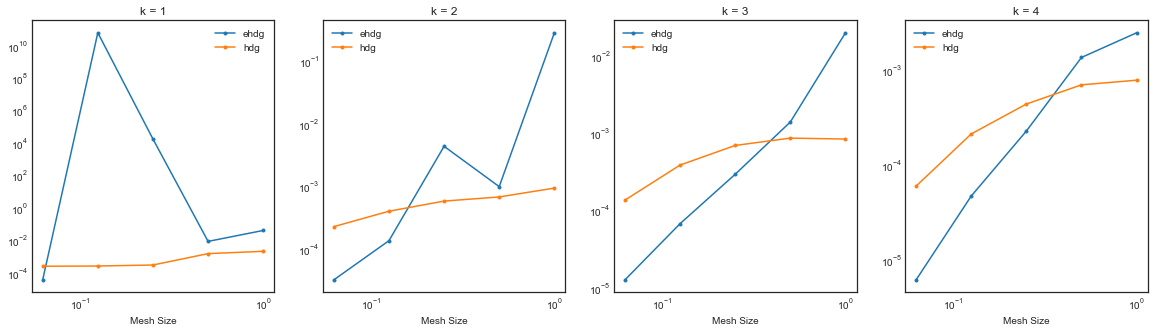

In [107]:
plot_error(complete)